<a href="https://colab.research.google.com/github/hursoo/FD_of_MAN/blob/main/jindan_2_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.개요
- 진단학보 논설 파악 위한 특징 추출

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 폴더 경로 지정
file_path = '/content/drive/MyDrive/_JINDAN/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## 런타임 다시 시작 후엔 이 셀 건너뛸 것 !

# =================================================================
# 1단계: 나눔 폰트 설치 (이 셀을 실행한 후, 런타임을 다시 시작해야 합니다)
# =================================================================
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
# 필요한 라이브러리 가져오기

import sys
import os, re
import pandas as pd
import numpy as np
import math # math: 수학 계산 함수 모음
import random
import warnings

import matplotlib.pyplot as plt # matplotlib.pyplot: 그래프 생성용, plt로 사용
import matplotlib as mpl # matplotlib: 그래프 스타일 및 설정 변경용, mpl로 사용
import matplotlib.font_manager as fm # matplotlib.font_manager: 그래프 글꼴 관리용, fm으로 사용
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕으로 설정 (Colab 기본 포함) ###
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 정상 표시되도록 설정

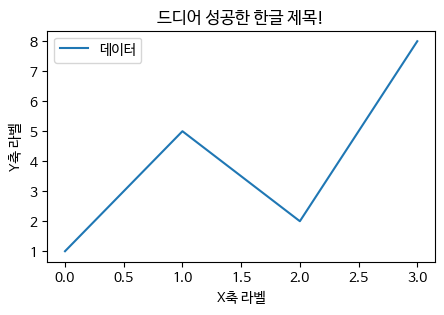

In [ ]:
# --- 이제 그래프를 그려도 경고가 뜨지 않습니다. ---

# 예시 그래프
# (여기에 원래 그리려던 그래프 코드를 넣으시면 됩니다)
plt.figure(figsize=(5, 3))
plt.title('드디어 성공한 한글 제목!')
plt.xlabel('X축 라벨')
plt.ylabel('Y축 라벨')
plt.plot([1, 5, 2, 8], label='데이터')
plt.legend()
plt.show()

# 2.주요 데이터 불러오기

In [ ]:
# 특성 파악 위한 자료들

features = pd.read_excel(file_path + 'data/features.xlsx', index_col = 0) # 논설 구분 위한 주요 특성들
combined_char_count = pd.read_excel(file_path + 'result/main-anno_count(by_term).xlsx', index_col = 0) # 본문 및 주석 글자수 (논설별)
main_count = pd.read_excel(file_path + 'result/main_count.xlsx', index_col = 0) # 본문 글자수
anno_count = pd.read_excel(file_path + 'result/anno_count.xlsx', index_col = 0) # 주석 글자수

In [ ]:
# 특성 항목 파일 열기 (f1, f7, f8은 입력)

print(features.shape)
features.head()

(59, 10)


,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol
No,,,,,,,,,,
1,이병도(jdh193411a),三韓問題의 新考察(一)-辰國及三韓考-,있음,25,NaN,NaN,NaN,NaN,1934.11,1
2,이상백(jdh193411),庶孽 差待의 淵源에 對한 一問題,없음,30,NaN,NaN,NaN,NaN,1934.11,1
3,조윤제(jdh193411),朝鮮詩歌의 胎生,있음,30,NaN,NaN,NaN,NaN,1934.11,1
4,김상기(jdh193411),古代의 貿易形態와 羅末의 海上發展에 就하야 (一)-淸海鎭大使張保皐를 主로 하야-,있음,27,NaN,NaN,NaN,NaN,1934.11,1
5,손진태(jdh193411),朝鮮 古代 山神의 性에 就하야,없음,11,NaN,NaN,NaN,NaN,1934.11,1


# 3.논설 규모(f2) 삽입
- 논설 규모: 본문과 주석의 글자수를 합친 것

In [ ]:
# 앞에서 산출한 글자 수 정보 불러오기

combined_char_count.head()
chars_info = combined_char_count.rename(columns = {'CharCount_x':'main_chars', 'CharCount_y':'anno_chars', 'TotalChars':'total_chars'})
print(chars_info.shape)
chars_info.head()

(59, 3)


,main_chars,anno_chars,total_chars
TermId,,,
고유섭(jdh193509),13451,2021,15472
고유섭(jdh193611),16057,3484,19541
고유섭(jdh193711),10187,2544,12731
고유섭(jdh193904),23836,4024,27860
김두헌(jdh193912),31816,3531,35347


In [ ]:
# 특성 df를 기사id로 정렬

feat_df_f178 = features.sort_values('GisaId')
print(feat_df_f178.shape)
feat_df_f178.head()

(59, 10)


,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol
No,,,,,,,,,,
14,고유섭(jdh193509),高麗畵跡 對하야,있음,23,NaN,NaN,NaN,NaN,1935.09,3
24,고유섭(jdh193611),朝鮮塔婆의 研究,있음,31,NaN,NaN,NaN,NaN,1936.11,6
32,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,17,NaN,NaN,NaN,NaN,1937.11,8
41,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,41,NaN,NaN,NaN,NaN,1939.04,10
48,김두헌(jdh193912),朝鮮妾制史小考,있음,51,NaN,NaN,NaN,NaN,1939.12,11


In [ ]:
# f2변수에 '논문 전체 크기' 삽입

feat_df_f1278 = feat_df_f178.copy()
feat_df_f1278['f2_size'] = chars_info['total_chars'].tolist()
print(feat_df_f1278.shape)
feat_df_f1278.head()

(59, 10)


,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol
No,,,,,,,,,,
14,고유섭(jdh193509),高麗畵跡 對하야,있음,15472,NaN,NaN,NaN,NaN,1935.09,3
24,고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,NaN,NaN,NaN,NaN,1936.11,6
32,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,NaN,NaN,NaN,NaN,1937.11,8
41,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,NaN,NaN,NaN,NaN,1939.04,10
48,김두헌(jdh193912),朝鮮妾制史小考,있음,35347,NaN,NaN,NaN,NaN,1939.12,11


#4.주석 관련 특성(f4,5,6) 삽입
- 주석 개수(f4): 상대빈도 사용. 즉 주석 개수(절대수)를 논설 규모(f2)로 나눈 것.
- 주석 규모(f5): 상대규모 사용. 즉 주석 글자수를 논설 규모(f2)로 나눈 것.
- 주석 평균 길이(f6): 주석 글자수를 주석 개수(f4)로 나눈 것.

## 4.1.주석 개수(절대수)

In [ ]:
#1. 주석 개수
print(anno_count.shape)
anno_count.head()

(1057, 7)


,FootId,TermId,RawFtNo,RefSplit,FpClass,CharSize,CharCount
No,,,,,,,
1,고유섭(jdh193509)_1,고유섭(jdh193509),1,"槿域書畵徵에는 獻宗을 들지 않았으나, 高麗史에는「性聰彗九歲好書畵」라 하였고, 또「王...",FpAll,NaN,70
2,고유섭(jdh193509)_2,고유섭(jdh193509),2,"이 亦 槿域書畵徵에는 書家로서 만들었으나, 高麗史에는 「自少多才壽, 曉音律善書畵」라...",FpAll,NaN,43
3,고유섭(jdh193509)_3,고유섭(jdh193509),3,"金安老 龍泉談寂記에 「高麗忠宣王在燕邸,構萬巷堂, 召李齊賢置府中, 與元學士姚遂·閻復·...",FpAll,NaN,119
4,고유섭(jdh193509)_4,고유섭(jdh193509),4,그 例는 槿域書畵徵에서 찾아볼지어다.,FpAll,NaN,17
5,고유섭(jdh193509)_5,고유섭(jdh193509),5,"朝鮮金石總覽上, 智勒寺廣智大禪師墓誌.",FpAll,NaN,19


In [ ]:
# 논설별 주석 개수 (전산화 미비로 별도 계산한 주석 수 포함)

anno_by_term_count = anno_count.groupby('TermId')['RawFtNo'].agg('count')
anno_by_term_count['유홍렬(jdh193607)'] = anno_by_term_count['유홍렬(jdh193607)'] + 49 - 1
anno_by_term_count['이상백(jdh193504)'] = anno_by_term_count['이상백(jdh193504)'] + 69 - 1

print(anno_by_term_count.shape)
anno_by_term_count.head(10)

(42,)


,RawFtNo
TermId,
고유섭(jdh193509),17
고유섭(jdh193611),53
고유섭(jdh193711),21
고유섭(jdh193904),25
김두헌(jdh193912),90
김상기(jdh193411),46
김상기(jdh193504),22
김상기(jdh193607),13
김상기(jdh193807),20


## 4.2.주석관련 상대빈도 산출

In [ ]:
chars_info.head()

,main_chars,anno_chars,total_chars
TermId,,,
고유섭(jdh193509),13451,2021,15472
고유섭(jdh193611),16057,3484,19541
고유섭(jdh193711),10187,2544,12731
고유섭(jdh193904),23836,4024,27860
김두헌(jdh193912),31816,3531,35347


In [ ]:
# 주석 관련 특성 마련

anno_temp_1 = pd.merge(chars_info, anno_by_term_count, how = 'left', left_on = 'TermId', right_on = anno_by_term_count.index)
anno_temp_2 = anno_temp_1.fillna('0')
anno_temp_2['RawFtNo'] = anno_temp_2['RawFtNo'].astype('int')
anno_temp_3 = anno_temp_2.rename(columns = {'RawFtNo':'anno_count'})
anno_temp_3.head()

,TermId,main_chars,anno_chars,total_chars,anno_count
0,고유섭(jdh193509),13451,2021,15472,17
1,고유섭(jdh193611),16057,3484,19541,53
2,고유섭(jdh193711),10187,2544,12731,21
3,고유섭(jdh193904),23836,4024,27860,25
4,김두헌(jdh193912),31816,3531,35347,90


In [ ]:
# 주석의 상대개수
anno_temp_3['anno_rela_count'] = round(anno_temp_3['anno_count'] / anno_temp_3['total_chars'] * 100000, 2)
anno_temp_3.head()

# 주석의 상대크기
anno_temp_3['anno_rela_size'] = round(anno_temp_3['anno_chars'] / anno_temp_3['total_chars'] * 1000, 2)
anno_temp_3.head()

print(anno_temp_3.shape)

# 주석의 평균길이
anno_temp_3['anno_aver_length'] = round(anno_temp_3['anno_chars'] / anno_temp_3['anno_count'], 2)
anno_temp_3.head()


(59, 7)


,TermId,main_chars,anno_chars,total_chars,anno_count,anno_rela_count,anno_rela_size,anno_aver_length
0,고유섭(jdh193509),13451,2021,15472,17,109.88,130.62,118.88
1,고유섭(jdh193611),16057,3484,19541,53,271.22,178.29,65.74
2,고유섭(jdh193711),10187,2544,12731,21,164.95,199.83,121.14
3,고유섭(jdh193904),23836,4024,27860,25,89.73,144.44,160.96
4,김두헌(jdh193912),31816,3531,35347,90,254.62,99.90,39.23


## 4.3.cf)주석 관련 값 분포 파악

In [ ]:
# cf) 값 분포

anno_temp_4_boxplot = anno_temp_3.iloc[:, [0, 1, 2, 4, -1]]
anno_temp_4_boxplot.head()

,TermId,main_chars,anno_chars,anno_count,anno_aver_length
0,고유섭(jdh193509),13451,2021,17,118.88
1,고유섭(jdh193611),16057,3484,53,65.74
2,고유섭(jdh193711),10187,2544,21,121.14
3,고유섭(jdh193904),23836,4024,25,160.96
4,김두헌(jdh193912),31816,3531,90,39.23


In [ ]:
import numpy as np
import pandas as pd # pandas DataFrame을 사용하고 있으므로 필요

# --- calculate_boxplot_min_max 함수 ---
def calculate_boxplot_min_max(data):
    """
    상자 그림에서 사용되는 최소값(Lower Whisker)과 최대값(Upper Whisker)을 계산합니다.
    (이상치를 제외한 범위 내의 최소/최대 값)

    Args:
        data (pandas.Series 또는 numpy.array): 숫자형 데이터 Series 또는 배열.

    Returns:
        tuple: (boxplot_min, boxplot_max) - 이상치를 제외한 최소값과 최대값.
               데이터가 너무 적거나 모든 값이 이상치인 경우 None을 반환할 수 있습니다.
    """
    # 데이터가 비어있는지 확인 (Pandas Series와 다른 iterable 모두 처리)
    if isinstance(data, pd.Series):
        if data.empty:
            return None, None
    elif not data:
        return None, None

    data = np.array(data)

    # 데이터에 4분위수를 계산할 만큼 충분한 데이터 포인트가 있는지 확인
    if len(data) < 2:
        if len(data) == 1:
            return data[0], data[0] # 데이터가 하나뿐이면 그 값이 최소이자 최대
        return None, None

    # 1. 사분위수(Q1, Q3) 계산
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # 2. 사분위수 범위(IQR) 계산
    IQR = Q3 - Q1

    # 3. 이상치 경계선 계산
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 4. 이상치를 제외한 데이터 필터링
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

    # 5. 필터링된 데이터에서 최소값과 최대값 찾기
    if len(filtered_data) > 0:
        boxplot_min = np.min(filtered_data)
        boxplot_max = np.max(filtered_data)
    else:
        boxplot_min = None
        boxplot_max = None
        # print("경고: 이상치를 제외한 유효한 데이터가 없습니다. 원본 데이터의 최소/최대값이 아닐 수 있습니다.") # 주석 처리 유지

    return boxplot_min, boxplot_max



# --- 각 숫자형 열의 주요 통계 (최대값, 중앙값, 최소값 순) ---
numerical_cols = ['main_chars', 'anno_chars', 'anno_count', 'anno_aver_length']

# 각 열의 중앙값 계산
all_medians = anno_temp_4_boxplot[numerical_cols].median()

# 각 열의 상자 그림 방식의 최소/최대값 계산
boxplot_min_values = {}
boxplot_max_values = {}

for col in numerical_cols:
    min_val, max_val = calculate_boxplot_min_max(anno_temp_4_boxplot[col].dropna())
    boxplot_min_values[col] = min_val
    boxplot_max_values[col] = max_val

print("--- 각 열의 주요 통계 (상자 그림 방식 최대값, 중앙값, 상자 그림 방식 최소값 순) ---")

# 출력을 위한 DataFrame 생성 또는 수동 정렬
results = pd.DataFrame({
    'boxplot_max': boxplot_max_values,
    'median': all_medians,
    'boxplot_min': boxplot_min_values
})

# 원하는 순서대로 열 정렬 (max, median, min)
results = results[['boxplot_max', 'median', 'boxplot_min']]
print(results)

--- 각 열의 주요 통계 (상자 그림 방식 최대값, 중앙값, 상자 그림 방식 최소값 순) ---
                  boxplot_max   median  boxplot_min
main_chars           38711.00  16057.0      2706.00
anno_chars            4024.00    633.0         0.00
anno_count              78.00     13.0         0.00
anno_aver_length       310.56     66.8        15.26


In [ ]:
!pip install seaborn

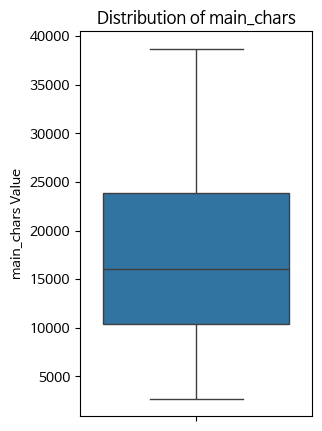

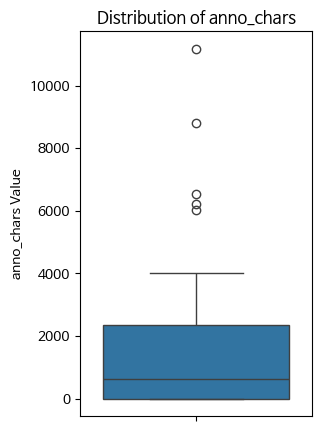

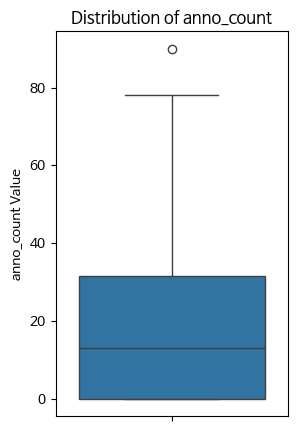

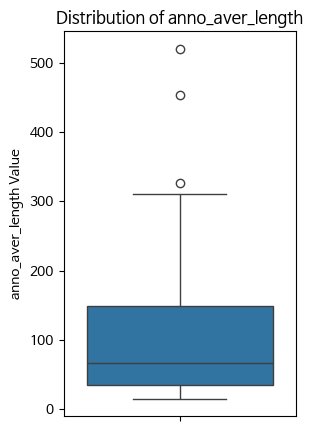

In [ ]:

import seaborn as sns

# 'main_chars' 열에 대한 상자 그림
plt.figure(figsize=(3, 5))
sns.boxplot(y=anno_temp_4_boxplot['main_chars'])
plt.title('Distribution of main_chars')
plt.ylabel('main_chars Value')
plt.show()

# 'anno_chars' 열에 대한 상자 그림
plt.figure(figsize=(3, 5))
sns.boxplot(y=anno_temp_4_boxplot['anno_chars'])
plt.title('Distribution of anno_chars')
plt.ylabel('anno_chars Value')
plt.show()

# 'anno_count' 열에 대한 상자 그림
plt.figure(figsize=(3, 5))
sns.boxplot(y=anno_temp_4_boxplot['anno_count'])
plt.title('Distribution of anno_count')
plt.ylabel('anno_count Value')
plt.show()

# 'anno_aver_length' 열에 대한 상자 그림
plt.figure(figsize=(3, 5))
sns.boxplot(y=anno_temp_4_boxplot['anno_aver_length'])
plt.title('Distribution of anno_aver_length')
plt.ylabel('anno_aver_length Value')
plt.show()


## 4.4.주석 관련 특성 삽입

In [ ]:
# 특성 df에 채워넣기

feat_df_f1278.head()

,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol
No,,,,,,,,,,
14,고유섭(jdh193509),高麗畵跡 對하야,있음,15472,NaN,NaN,NaN,NaN,1935.09,3
24,고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,NaN,NaN,NaN,NaN,1936.11,6
32,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,NaN,NaN,NaN,NaN,1937.11,8
41,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,NaN,NaN,NaN,NaN,1939.04,10
48,김두헌(jdh193912),朝鮮妾制史小考,있음,35347,NaN,NaN,NaN,NaN,1939.12,11


In [ ]:
feat_df_f1245678 = feat_df_f1278.copy()
feat_df_f1245678['f4_anno_count'] = anno_temp_3['anno_rela_count'].tolist()
feat_df_f1245678['f5_anno_size'] = anno_temp_3['anno_rela_size'].tolist()
feat_df_f1245678['f6_anno_length'] = anno_temp_3['anno_aver_length'].tolist()
print(feat_df_f1245678.shape)
feat_df_f1245678.head()

(59, 10)


,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol
No,,,,,,,,,,
14,고유섭(jdh193509),高麗畵跡 對하야,있음,15472,NaN,109.88,130.62,118.88,1935.09,3
24,고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,NaN,271.22,178.29,65.74,1936.11,6
32,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,NaN,164.95,199.83,121.14,1937.11,8
41,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,NaN,89.73,144.44,160.96,1939.04,10
48,김두헌(jdh193912),朝鮮妾制史小考,있음,35347,NaN,254.62,99.90,39.23,1939.12,11


In [ ]:
# f1 현황

feat_df_f1245678.groupby('f1_divider')['GisaId'].agg('count')

,GisaId
f1_divider,
번호만,5
없음,12
있음,42


# 5.자료 규모(f3) 삽입

- 구간별 한자 밀도 계산
- 공백 제외한 글자가 있는 Content 열을 대상으로 작업을 하려 한다.
- 목적은 한글(옛한글 포함) 대비 한자의 비율(여기서 '한자'는 한글과 다른 문자로서 한자 뿐 아니라 영어, 일본어, 기타 외국어도 모두 포함한다)
- 한자 비율은 구두점, 특수문자 등 모두 제외하고,
- '한자' 개수 / (옛)한글, '한자' 등 전체 개수
- 값을 소수점 한 자리가지 산출한 것을 말한다. (개수에서 공백은 처음부터 제외한다)

## 5.1.구간별 한자 비율 구하기

### 5.1.1.본문을 구간으로 나누기
- 50글자 기준

In [ ]:
import re # 정규 표현식 모듈을 가져옵니다. 텍스트에서 특정 패턴을 찾거나 변경할 때 사용돼요.

# --- 정규식 패턴 정의 ---
# 다양한 문자 유형을 찾기 위한 정규식 패턴들을 미리 컴파일해서 준비해둡니다.
# 이렇게 하면 반복적으로 사용할 때 더 빠르게 동작해요.

# 한글 찾기 패턴: 완성형 한글 음절(가-힣), 한글 자모(ᄀ-ᇿ), 호환용 한글 자모(ㄱ-ㆎ)를 포함합니다.
hangul_pattern = re.compile(r'[가-힣ᄀ-ᇿㄱ-ㆎ]')

# 한자 찾기 패턴: 일반적인 한자(一-龥)와 숫자 0을 나타내는 한자(〇)를 포함합니다.
hanja_pattern = re.compile(r'[一-龥〇]')

# 히라가나 찾기 패턴: 일본어 히라가나 문자(ぁ-ん)를 찾습니다.
hiragana_pattern = re.compile(r'[ぁ-ん]')

# 가타카나 찾기 패턴: 일본어 가타카나 문자(ァ-ン)를 찾습니다.
katakana_pattern = re.compile(r'[ァ-ン]')

# 알파벳 찾기 패턴: 영어 대문자(A-Z)와 소문자(a-z)를 찾습니다.
alphabet_pattern = re.compile(r'[A-Za-z]')

# 숫자 찾기 패턴: 0부터 9까지의 숫자를 찾습니다.
number_pattern = re.compile(r'[0-9]')

# 특정 문자 제외 패턴: 아래 주석 처리된 함수들에서는 직접 사용되지 않지만,
# 단어 문자(\w - 알파벳, 숫자, 밑줄), 한글, 한자, 히라가나, 가타카나, 알파벳, 숫자를 제외한
# 다른 모든 문자를 찾는 패턴입니다. 특수 기호 등을 찾을 때 유용할 수 있어요.
exclude_pattern = re.compile(r'[^\w가-힣ᄀ-ᇿㄱ-ㆎ一-龥ぁ-んァ-ンA-Za-z0-9]')

# --- 함수 정의 ---

def preprocess_content(content: str) -> str:
    """
    입력된 문자열에서 모든 공백 문자를 제거합니다.
    예: "안 녕 하세요" -> "안녕하세요"

    Args:
        content (str): 전처리할 원본 문자열입니다.

    Returns:
        str: 공백이 제거된 문자열을 반환합니다.
    """
    # 문자열 내의 모든 공백(' ')을 빈 문자열('')로 치환합니다.
    # 이를 통해 구두점 등 다른 문자들은 그대로 유지하면서 공백만 제거할 수 있습니다.
    return content.replace(' ', '')

def split_into_grids(content: str, term_id: str, start_idx: int) -> tuple[list[str], list[str]]:
    """
    주어진 문자열(content)을 50글자 단위로 나누고, 각 부분에 대한 고유 ID를 생성합니다.
    논문이나 긴 텍스트를 특정 단위로 나누어 처리할 때 유용합니다.

    Args:
        content (str): 50글자 단위로 나눌 전체 문자열입니다.
        term_id (str): 생성될 ID의 접두사로 사용될 문자열입니다. (예: 'paper01')
        start_idx (int): ID 생성 시 시작 번호입니다. (예: 1)

    Returns:
        tuple[list[str], list[str]]: 생성된 ID 목록과 50글자 단위로 나누어진 문자열 목록의 튜플을 반환합니다.
                                      (예: (['paper01-0001', 'paper01-0002'], ['50글자내용1', '50글자내용2']))
    """
    # 1. content 문자열을 50글자씩 나누어 리스트로 만듭니다.
    #    range(0, len(content), 50)은 0부터 content 길이만큼 50씩 증가하는 숫자열을 만듭니다.
    #    예: content 길이가 120이면 i는 0, 50, 100이 됩니다.
    #    content[i:i+50]은 i번째부터 i+50번째 앞까지의 부분 문자열을 의미합니다.
    grids = [content[i:i+50] for i in range(0, len(content), 50)]

    # 2. 각 grid에 대한 고유 ID를 생성합니다.
    #    f-string을 사용하여 term_id와 순번(start_idx부터 시작)을 조합합니다.
    #    str(start_idx + idx).zfill(4)는 순번을 4자리 문자열로 만들고, 앞을 0으로 채웁니다. (예: 1 -> "0001")
    grid_ids = [f"{term_id}-{str(start_idx + idx).zfill(4)}" for idx in range(len(grids))]

    return grid_ids, grids

def calculate_hanja_ratio(grid: str) -> float:
    """
    주어진 문자열(grid) 내에서 특정 문자들의 비율을 계산합니다.
    여기서는 (한자 + 히라가나 + 가타카나 + 알파벳) / (한글 + 한자 + 히라가나 + 가타카나 + 알파벳) 비율을 계산합니다.
    결과는 소수점 둘째 자리까지 반올림됩니다.

    Args:
        grid (str): 비율을 계산할 대상 문자열입니다.

    Returns:
        float: 계산된 문자 비율을 반환합니다. 문자가 전혀 없는 경우 0.0을 반환합니다.
    """
    # 각 문자 유형별로 grid 내에 몇 개가 있는지 세어봅니다.
    # pattern.findall(grid)는 grid에서 pattern에 맞는 모든 부분을 찾아 리스트로 반환합니다.
    # len() 함수는 이 리스트의 길이를 반환하여 해당 문자의 개수를 얻습니다.
    hangul_count = len(hangul_pattern.findall(grid))      # 한글 개수
    hanja_count = len(hanja_pattern.findall(grid))        # 한자 개수
    hiragana_count = len(hiragana_pattern.findall(grid))  # 히라가나 개수
    katakana_count = len(katakana_pattern.findall(grid))  # 가타카나 개수
    alphabet_count = len(alphabet_pattern.findall(grid))  # 알파벳 개수

    # 비율 계산 시 분자에 해당하는 문자들(한글이 아닌 주요 외국 문자)의 총 개수를 계산합니다.
    non_hangul_text_count = hanja_count + hiragana_count + katakana_count + alphabet_count

    # 비율 계산 시 분모에 해당하는 문자들(한글 + 위에서 센 외국 문자)의 총 개수를 계산합니다.
    # 이 계산에는 숫자나 일반 특수기호는 포함되지 않습니다.
    total_relevant_chars = hangul_count + non_hangul_text_count

    # 분모가 0이면 (즉, 관련된 문자가 하나도 없으면) 0.0을 반환하여 0으로 나누는 오류를 방지합니다.
    if total_relevant_chars == 0:
        return 0.0

    # (한글 외 주요 문자 수) / (한글 + 한글 외 주요 문자 수) 비율을 계산하고,
    # round 함수를 사용해 소수점 둘째 자리까지 반올림합니다.
    ratio = non_hangul_text_count / total_relevant_chars
    return round(ratio, 2)

In [ ]:
# 작업대상 불러오기
print(main_count.shape)
main_count.head()

(3680, 5)


,PhrId,TermId,Content,Content_Cleaned,CharCount
No,,,,,
1,고유섭(jdh193509)P109,고유섭(jdh193509),쪽수▶P109一般으로 朝鮮文化 方面이 다 그러하지만 美術工藝品에 있어서도 文獻 乃至...,一般으로 朝鮮文化 方面이 다 그러하지만 美術工藝品에 있어서도 文獻 乃至 遺跡이 稀貴...,1649
2,고유섭(jdh193509)P111-2,고유섭(jdh193509),元來 繪畫의 始源이 人物畫에 있었음은 作畫衝動이 發揮되기 시작하는 兒童의 戱畫에 도...,元來 繪畫의 始源이 人物畫에 있었음은 作畫衝動이 發揮되기 시작하는 兒童의 戱畫에 도...,439
3,고유섭(jdh193509)P112-2,고유섭(jdh193509),"黃胤錫 頤齋集에 髙麗 眞殿의 源始說이 있으니 하였으되 漢制自諸帝各廟在京師者外, 別立...","黃胤錫 頤齋集에 髙麗 眞殿의 源始說이 있으니 하였으되 漢制自諸帝各廟在京師者外, 別立...",743
4,고유섭(jdh193509)P113-2,고유섭(jdh193509),"이밖에 陵廟에도 眞殿이 있었음은 世祖 昌陵의 眞殿이 그 一例요, 正陵 丁字閣에 있던...","이밖에 陵廟에도 眞殿이 있었음은 世祖 昌陵의 眞殿이 그 一例요, 正陵 丁字閣에 있던...",922
5,고유섭(jdh193509)P114-2,고유섭(jdh193509),"以外에도 上述한 寺社眞殿 外에 麗史 兵制에 弘圓寺 九祖 堂, 興王寺, 大雲寺, 重光...","以外에도 上述한 寺社眞殿 外에 麗史 兵制에 弘圓寺 九祖 堂, 興王寺, 大雲寺, 重光...",112


### 5.1.2.구간(단락)별 한자 비율

In [ ]:
# 위 함수들을 실행하는 함수
def excute_hanja_ratio_by_50char(df):

    processed_data = []
    for term_id, group in df.groupby('TermId'):  # 논문별로 처리
        local_idx = 1  # 논문별로 일련번호 초기화
        for _, row in group.iterrows():
            content = preprocess_content(str(row['Content_Cleaned']))
            grid_ids, grids = split_into_grids(content, term_id, local_idx)
            local_idx += len(grids)  # 논문 내에서 구간 번호 유지
            for grid_id, grid in zip(grid_ids, grids):
                hanja_ratio = calculate_hanja_ratio(grid)
                processed_data.append({
                    'No': row['No'],
                    'TermId': term_id,
                    'GridID': grid_id,
                    'GridContent': grid,
                    'HanjaRatio': hanja_ratio
                })

    # 결과 데이터프레임 생성
    result = pd.DataFrame(processed_data)
    return result

In [ ]:
# 50글자를 단위로 한자 비율 산출

main_count_1 = main_count.reset_index(drop = False)
hanja_ratio_by50 = excute_hanja_ratio_by_50char(main_count_1)
hanja_ratio_by50

,No,TermId,GridID,GridContent,HanjaRatio
0,1,고유섭(jdh193509),고유섭(jdh193509)-0001,一般으로朝鮮文化方面이다그러하지만美術工藝品에있어서도文獻乃至遺跡이稀貴한中特히上古에있어서...,0.50
1,1,고유섭(jdh193509),고유섭(jdh193509)-0002,오히려無怪한편이나僅僅五百年前乃至千年前間의高麗의畫跡에있어서도그러함은奇怪를지나처摩訶不可...,0.52
2,1,고유섭(jdh193509),고유섭(jdh193509)-0003,이라할만하다.論者있어그理由를說明하여가로되或은兵禍不息을擧證하고或은藝道에對한一般의無敎無...,0.51
3,1,고유섭(jdh193509),고유섭(jdh193509)-0004,會하나前論은오히려事實에近似하지만後論은一段의檢討를經하여야할것이爲先筆者가當場에問題하고있...,0.48
4,1,고유섭(jdh193509),고유섭(jdh193509)-0005,藝道에對한愛好가凡論常識으로써議할바아니어서斷簡尺素散見되는記錄에서나마一大豪華版을그려낼수...,0.48
...,...,...,...,...,...
22422,3801,조윤제(jdh194009),조윤제(jdh194009)-0620,이없을뿐아니라또한發展도적다.春香傳異本이獄中花以後큰飛躍的發展이없었다는것은곧그러한社會情...,0.43
22423,3801,조윤제(jdh194009),조윤제(jdh194009)-0621,"주는것이아닌가하고보고있으나,여기에또앞날의朝鮮文學進路를暗示함이있는듯도하다.",0.21
22424,3802,조윤제(jdh194009),조윤제(jdh194009)-0622,끝으로本稿는于先이로써마감하고자하는데아직〿譯文春香傳의研究를남겨두었다.後日春香歌의研究와...,0.40
22425,3802,조윤제(jdh194009),조윤제(jdh194009)-0623,理하여發表할機會를얻고자하나이번에는本論文을씀에當하여普專圖書舘과李明善氏外諸氏로부터는貴重...,0.50


In [ ]:
import pandas as pd

def generate_size_cls(df):
    # 1. GridContent 글자 수를 세어서 'size' 열에 입력
    df['size'] = df['GridContent'].apply(len)

    # 2. HanjaRatio에 따라 'cls' 열에 'data' 또는 'description' 입력
    df['cls'] = df['HanjaRatio'].apply(lambda x: 'sources' if x >= 0.9 else 'narration')

    # 결과 출력
    return df

In [ ]:
hanja_ratio_by50 = hanja_ratio_by50.copy()
hanja_ratio_by50_classified = generate_size_cls(hanja_ratio_by50)
hanja_ratio_by50_classified

,No,TermId,GridID,GridContent,HanjaRatio,size,cls
0,1,고유섭(jdh193509),고유섭(jdh193509)-0001,一般으로朝鮮文化方面이다그러하지만美術工藝品에있어서도文獻乃至遺跡이稀貴한中特히上古에있어서...,0.50,50,narration
1,1,고유섭(jdh193509),고유섭(jdh193509)-0002,오히려無怪한편이나僅僅五百年前乃至千年前間의高麗의畫跡에있어서도그러함은奇怪를지나처摩訶不可...,0.52,50,narration
2,1,고유섭(jdh193509),고유섭(jdh193509)-0003,이라할만하다.論者있어그理由를說明하여가로되或은兵禍不息을擧證하고或은藝道에對한一般의無敎無...,0.51,50,narration
3,1,고유섭(jdh193509),고유섭(jdh193509)-0004,會하나前論은오히려事實에近似하지만後論은一段의檢討를經하여야할것이爲先筆者가當場에問題하고있...,0.48,50,narration
4,1,고유섭(jdh193509),고유섭(jdh193509)-0005,藝道에對한愛好가凡論常識으로써議할바아니어서斷簡尺素散見되는記錄에서나마一大豪華版을그려낼수...,0.48,50,narration
...,...,...,...,...,...,...,...
22422,3801,조윤제(jdh194009),조윤제(jdh194009)-0620,이없을뿐아니라또한發展도적다.春香傳異本이獄中花以後큰飛躍的發展이없었다는것은곧그러한社會情...,0.43,50,narration
22423,3801,조윤제(jdh194009),조윤제(jdh194009)-0621,"주는것이아닌가하고보고있으나,여기에또앞날의朝鮮文學進路를暗示함이있는듯도하다.",0.21,40,narration
22424,3802,조윤제(jdh194009),조윤제(jdh194009)-0622,끝으로本稿는于先이로써마감하고자하는데아직〿譯文春香傳의研究를남겨두었다.後日春香歌의研究와...,0.40,50,narration
22425,3802,조윤제(jdh194009),조윤제(jdh194009)-0623,理하여發表할機會를얻고자하나이번에는本論文을씀에當하여普專圖書舘과李明善氏外諸氏로부터는貴重...,0.50,50,narration


## 5.2.논설별 한자 비율

### 5.2.1.논설별 한자비율 집계

In [ ]:
import pandas as pd
import io

# TermId와 class를 기준으로 size를 합산하고, class를 컬럼으로 분리합니다.
# 1. groupby()를 사용하여 'TermId'와 'class'별로 데이터를 그룹화합니다.
# 2. .agg({'size': 'sum'})을 사용하여 각 그룹의 'size' 열을 합산합니다.
# 3. .unstack()을 사용하여 'class' 레벨의 인덱스를 컬럼으로 변환합니다.
df_summed_by_class = hanja_ratio_by50_classified.groupby(['TermId', 'cls']).agg(
    sum_size=('size', 'sum') # 'sum_size'라는 이름으로 size의 합계를 구합니다.
).unstack(fill_value=0) # unstack 시 NaN 값은 0으로 채웁니다.

# 컬럼명 정리
# unstack() 결과로 다중 인덱스 컬럼이 생길 수 있으므로, 단일 레벨로 평탄화합니다.
df_summed_by_class.columns = [f"{col[1]}_size_sum" for col in df_summed_by_class.columns]

# TermId를 다시 일반 컬럼으로 변환 (선택 사항)
df_summed_by_class = df_summed_by_class.reset_index()

print(df_summed_by_class.shape)
df_summed_by_class.head()

(59, 3)


,TermId,narration_size_sum,sources_size_sum
0,고유섭(jdh193509),11236,2215
1,고유섭(jdh193611),15017,1040
2,고유섭(jdh193711),8402,1785
3,고유섭(jdh193904),21263,2577
4,김두헌(jdh193912),25075,6758


### 5.2.2.한자비율 분포 파악

In [ ]:
# 자료 비중의 전체 본포 확인 (boxplot)

# --- 각 숫자형 열에 상자 그림 방식의 최소/최대값 적용 ---
numerical_cols = ['narration_size_sum', 'sources_size_sum']

# 각 열의 중앙값 계산
all_medians = df_summed_by_class[numerical_cols].median()

# 각 열의 상자 그림 방식의 최소/최대값 계산
boxplot_min_values = {}
boxplot_max_values = {}

for col in numerical_cols:
    min_val, max_val = calculate_boxplot_min_max(df_summed_by_class[col].dropna())
    boxplot_min_values[col] = min_val
    boxplot_max_values[col] = max_val

print("--- 각 열의 주요 통계 (상자 그림 방식 최대값, 중앙값, 상자 그림 방식 최소값 순) ---")

# 출력을 위한 DataFrame 생성 또는 수동 정렬
results = pd.DataFrame({
    'boxplot_max': boxplot_max_values,
    'median': all_medians,
    'boxplot_min': boxplot_min_values
})

# 원하는 순서대로 열 정렬 (max, median, min)
results = results[['boxplot_max', 'median', 'boxplot_min']]
print(results)

--- 각 열의 주요 통계 (상자 그림 방식 최대값, 중앙값, 상자 그림 방식 최소값 순) ---
                    boxplot_max   median  boxplot_min
narration_size_sum        35225  14001.0            1
sources_size_sum           5600   1432.0            0


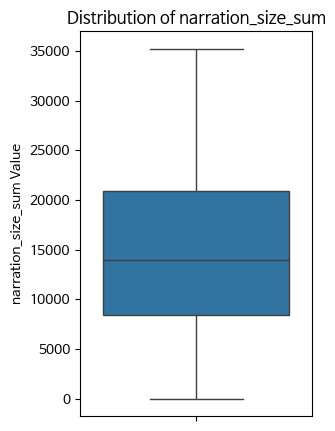

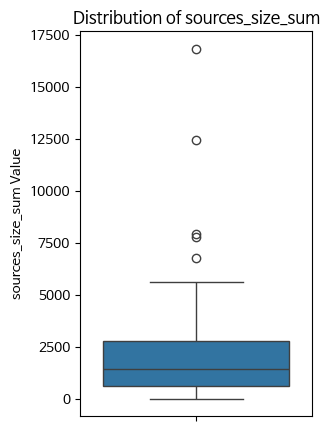

In [ ]:
# 'narration_size_sum' 열에 대한 상자 그림
plt.figure(figsize=(3, 5))
sns.boxplot(y=df_summed_by_class['narration_size_sum'])
plt.title('Distribution of narration_size_sum')
plt.ylabel('narration_size_sum Value')
plt.show()

# 'sources_size_sum' 열에 대한 상자 그림
plt.figure(figsize=(3, 5))
sns.boxplot(y=df_summed_by_class['sources_size_sum'])
plt.title('Distribution of sources_size_sum')
plt.ylabel('sources_size_sum Value')
plt.show()

## 5.3.자료 특성 합치기

In [ ]:
# 자료의 상대적 크기: 본문인용 자료 글자 수 / 본문 전체 글자 수

df_summed_by_class['source_rela_size'] = round(df_summed_by_class['sources_size_sum'] / (df_summed_by_class['narration_size_sum'] + df_summed_by_class['sources_size_sum']), 3)
df_summed_by_class_1 = df_summed_by_class.set_index('TermId')
df_summed_by_class_1

,narration_size_sum,sources_size_sum,source_rela_size
TermId,,,
고유섭(jdh193509),11236,2215,0.165
고유섭(jdh193611),15017,1040,0.065
고유섭(jdh193711),8402,1785,0.175
고유섭(jdh193904),21263,2577,0.108
김두헌(jdh193912),25075,6758,0.212
김상기(jdh193411),11532,917,0.074
김상기(jdh193504),8918,1432,0.138
김상기(jdh193607),10367,1262,0.109
김상기(jdh193807),14582,1416,0.089


In [ ]:
# 특성 df 불러와 확인
print(feat_df_f1245678.shape)
feat_df_f1245678.head()

(59, 10)


,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol
No,,,,,,,,,,
14,고유섭(jdh193509),高麗畵跡 對하야,있음,15472,NaN,109.88,130.62,118.88,1935.09,3
24,고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,NaN,271.22,178.29,65.74,1936.11,6
32,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,NaN,164.95,199.83,121.14,1937.11,8
41,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,NaN,89.73,144.44,160.96,1939.04,10
48,김두헌(jdh193912),朝鮮妾制史小考,있음,35347,NaN,254.62,99.90,39.23,1939.12,11


In [ ]:
df_summed_by_class.head()

,TermId,narration_size_sum,sources_size_sum,source_rela_size
0,고유섭(jdh193509),11236,2215,0.165
1,고유섭(jdh193611),15017,1040,0.065
2,고유섭(jdh193711),8402,1785,0.175
3,고유섭(jdh193904),21263,2577,0.108
4,김두헌(jdh193912),25075,6758,0.212


In [ ]:
# 자료 규모 정보를 삽입

feat_df_f12345678 = feat_df_f1245678.copy()
feat_df_f12345678['f3_src_size'] = df_summed_by_class_1['source_rela_size'].tolist()
feat_df_all = feat_df_f12345678.fillna('0')
feat_df_all

,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol
No,,,,,,,,,,
14,고유섭(jdh193509),高麗畵跡 對하야,있음,15472,0.165,109.88,130.62,118.88,1935.09,3
24,고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,0.065,271.22,178.29,65.74,1936.11,6
32,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,0.175,164.95,199.83,121.14,1937.11,8
41,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,0.108,89.73,144.44,160.96,1939.04,10
48,김두헌(jdh193912),朝鮮妾制史小考,있음,35347,0.212,254.62,99.90,39.23,1939.12,11
4,김상기(jdh193411),古代의 貿易形態와 羅末의 海上發展에 就하야 (一)-淸海鎭大使張保皐를 主로 하야-,있음,15484,0.074,297.08,196.01,65.98,1934.11,1
10,김상기(jdh193504),古代의 貿易形態와 羅末의 海上發展에 就하야 (二)-淸海鎭大使張保皐를 主로 하야-,있음,11674,0.138,188.45,113.41,60.18,1935.04,2
23,김상기(jdh193607),葛文王考,번호만,13539,0.109,96.02,141.07,146.92,1936.07,5
35,김상기(jdh193807),三別抄와 그의 亂에 就하야 (1),있음,18999,0.089,105.27,158.01,150.1,1938.07,9


In [ ]:
# 저장하기

feat_df_all.to_excel(file_path + 'result/feat_df_all.xlsx', index = False)

# The End of Note